In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error
from math import sqrt

In [2]:
df = pd.read_csv('monthly_milk_production.csv',index_col='Date',parse_dates=True)
df.index.freq='MS'

<AxesSubplot:xlabel='Date'>

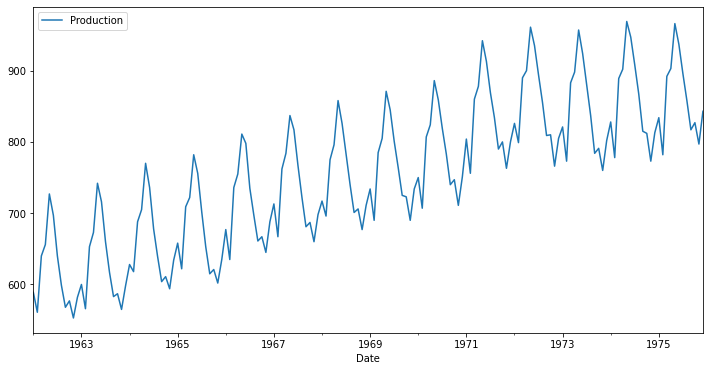

In [3]:
df.plot(figsize=(12,6))

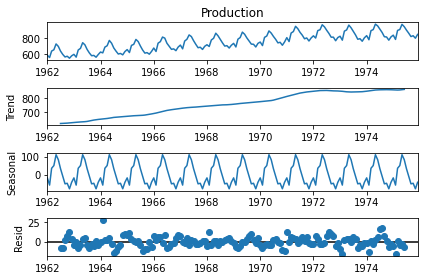

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose

results = seasonal_decompose(df['Production'])
results.plot();

In [5]:
# Segregating it as train and test data
train = df.iloc[:156]
test = df.iloc[156:]

In [6]:
# Initializing MinMax scaler to get value between 0 to 1
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [7]:
# define generator

# n for 12 months
n_input = 12
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [8]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [9]:
# fit model
model.fit(generator,epochs=50)

Epoch 1/50
144/144 [==============================] - 2s 4ms/step - loss: 0.0482
Epoch 2/50
144/144 [==============================] - 1s 4ms/step - loss: 0.0222
Epoch 3/50
144/144 [==============================] - 1s 5ms/step - loss: 0.0196
Epoch 4/50
144/144 [==============================] - 0s 3ms/step - loss: 0.0126
Epoch 5/50
144/144 [==============================] - 0s 3ms/step - loss: 0.0089
Epoch 6/50
144/144 [==============================] - 0s 3ms/step - loss: 0.0109
Epoch 7/50
144/144 [==============================] - 0s 3ms/step - loss: 0.0079
Epoch 8/50
144/144 [==============================] - 0s 3ms/step - loss: 0.0069
Epoch 9/50
144/144 [==============================] - 0s 3ms/step - loss: 0.0079
Epoch 10/50
144/144 [==============================] - 0s 3ms/step - loss: 0.0054
Epoch 11/50
144/144 [==============================] - 0s 3ms/step - loss: 0.0040
Epoch 12/50
144/144 [==============================] - 0s 3ms/step - loss: 0.0037
Epoch 13/50
144/144 [====

In [10]:
last_train_batch = scaled_train[-12:]
last_train_batch = last_train_batch.reshape((1, n_input, n_features))
model.predict(last_train_batch)

1/1 [==============================] - 0s 185ms/step


array([[0.6259959]], dtype=float32)

In [11]:
test_predictions = []

In [12]:
first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

In [13]:
for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 16ms/step


<AxesSubplot:xlabel='Date'>

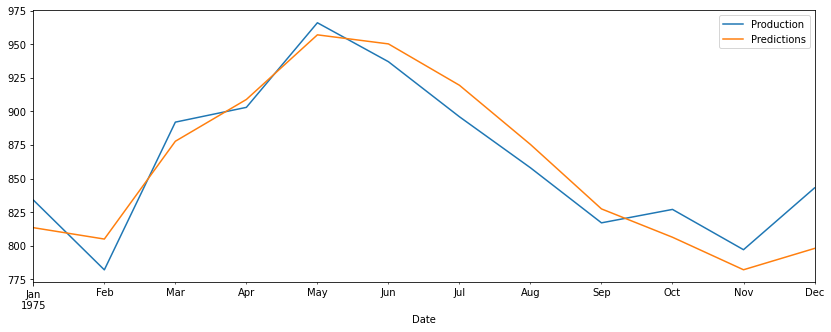

In [14]:
true_predictions = scaler.inverse_transform(test_predictions)
test['Predictions'] = true_predictions
test.plot(figsize=(14,5))

In [15]:
# Calculating MSE
rmse=sqrt(mean_squared_error(test['Production'],test['Predictions']))
print(rmse)

20.585763495766713
